In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
TRAIN_TEST_SPLIT = 3000
WINDOW_SIZE = 60
BATCH_SIZE = 100
SHUFFER_BUFFER_SIZE = 1000

In [3]:
time, series = utils.load_data()

t_train, x_train = time[:TRAIN_TEST_SPLIT], series[:TRAIN_TEST_SPLIT]
t_test, x_test = time[TRAIN_TEST_SPLIT:], series[TRAIN_TEST_SPLIT:]
print(f"x_train.shape = {x_train.shape}, x_test.shape = {x_test.shape}")

x_train.shape = (3000,), x_test.shape = (235,)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    expanded = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(expanded)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.cache()
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [5]:
train_data = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)
for x_batch, y_batch in train_data.take(1):
    print(x_batch.shape)
    print(y_batch.shape)

(100, 60, 1)
(100, 1)


In [6]:
def build_model(lr=1e-8):
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        keras.layers.LSTM(60, return_sequences=True), 
        keras.layers.LSTM(60), 
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 400.0)
    ])

    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mae'])
    return model

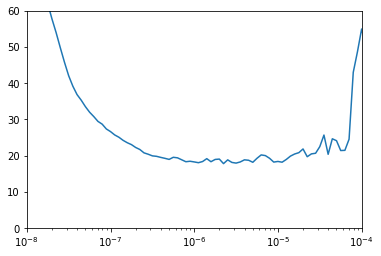

In [7]:
keras.backend.clear_session()

def lr_boost(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_schedule = keras.callbacks.LearningRateScheduler(lr_boost)
model = build_model(1e-8)
history = model.fit(train_data, epochs=100, callbacks=[lr_schedule], verbose=0)

plt.figure()
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

In [8]:
keras.backend.clear_session()

model = build_model(1e-6)

history = model.fit(train_data, epochs=500, verbose=0)

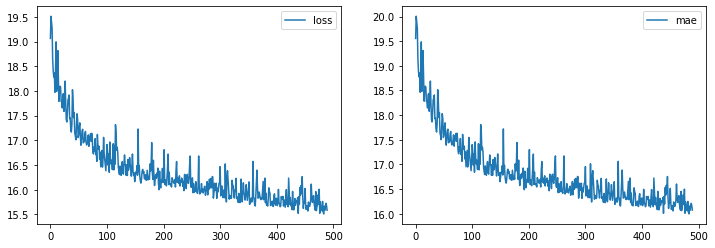

In [9]:
utils.plot_history(history, metrics=['loss', 'mae'], start=10)

mse = 450.6875, mae = 14.7964


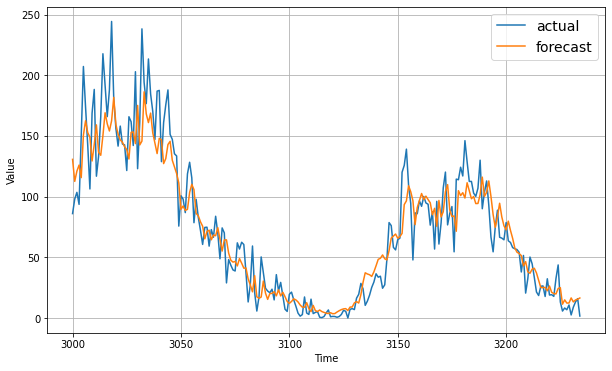

In [10]:
forecasts = []
for t in t_test:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, (0, -1)))[0][0]
    forecasts.append(forecast)

utils.evaluate(x_test, forecasts)

utils.plot_series(t_test, [x_test, forecasts], label=['actual', 'forecast'])